<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Required Libraries and Modules</h2>
</div>

**Note: This notebook is run in Paperspace platform**

In [1]:
!pip install transformers
!pip install imblearn
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 7.2 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 178.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.2/763.2 KB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 23.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 24.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895261 sha256=80c4fafde0a6f0b1d573d5cec5c240b0eb8795447c9611b2aae5d4cf4cbf5974
  Stored in directory: /tmp/pip-ephem-wheel-cache-hqzba07f/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 23.8 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,  classification_report
from imblearn.under_sampling import RandomUnderSampler

import torch
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback, set_seed

# Progress bar
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

/tmp/ipykernel_52/1605486461.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Import Clean Text Data</h2>
</div>

In [3]:
###############################################################
# Note: Change the name of data set used for feature creation
###############################################################
data_set='bully_data_clean_with_stopword'
    
    
###################
# Import Data Set #
###################
bully_data_cleaned = pd.read_csv('/datasets/data/bully_data_clean_with_stopword_short.csv', encoding='utf8')
bully_data_cleaned = bully_data_cleaned[~bully_data_cleaned['text_check'].isna()]
bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['text_check'] != ""]
#bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['role']!='None']
bully_data_cleaned = bully_data_cleaned[['role','text_check']]

def convert_role_label(x):
    if x == "None":
        return int(0)
    elif x == "Harasser":
        return int(1)
    elif x == "Victim":
        return int(2)
    elif x == "Bystander_defender":
        return int(3)
    elif x == "Bystander_assistant":
        return int(1)

bully_data_cleaned['label'] = bully_data_cleaned['role'].progress_apply(lambda x: convert_role_label(x)).astype(int)
bully_data_cleaned.rename(columns = {'text_check':'text'}, inplace = True)
bully_data_cleaned = bully_data_cleaned.reset_index(drop=True)

  0%|          | 0/112247 [00:00<?, ?it/s]

In [4]:
bully_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112247 entries, 0 to 112246
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   role    112247 non-null  object
 1   text    112247 non-null  object
 2   label   112247 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


In [5]:
bully_data_cleaned['label'].value_counts()

0    106872
1      3596
2      1354
3       425
Name: label, dtype: int64

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Define pretrained tokenizer and model</h2>
</div>

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# Define pretrained tokenizer and model

model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
set_seed(1127)
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                            num_labels=4,  
                                                            ignore_mismatched_sizes=True)
# def model_init():
#     return AutoModelForSequenceClassification.from_pretrained(model_name, 
#                                                             num_labels=4,  
#                                                             ignore_mismatched_sizes=True,
#                                                             output_attentions = False, # Whether the model returns attentions weights.
#                                                             output_hidden_states = False,
#                                                             return_dict=True )

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.bias

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Preprocess data</h2>
</div>

In [7]:
##############################
# Data: Text Input and Label #
##############################
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])


########################
# Create torch dataset #
########################
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


#############################
# Define Trainer parameters #
#############################
average_method = 'macro'
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average=average_method)
    precision = precision_score(y_true=labels, y_pred=pred, average=average_method)
    f1 = f1_score(y_true=labels, y_pred=pred, average=average_method)
    
    recall0 = recall_score(y_true=labels, y_pred=pred, average=None)[0]
    precision0 = precision_score(y_true=labels, y_pred=pred, average=None)[0]
    f10 = f1_score(y_true=labels, y_pred=pred, average=None)[0]
    
    recall1 = recall_score(y_true=labels, y_pred=pred, average=None)[1]
    precision1 = precision_score(y_true=labels, y_pred=pred, average=None)[1]
    f11 = f1_score(y_true=labels, y_pred=pred, average=None)[1]
    
    recall2 = recall_score(y_true=labels, y_pred=pred, average=None)[2]
    precision2 = precision_score(y_true=labels, y_pred=pred, average=None)[2]
    f12 = f1_score(y_true=labels, y_pred=pred, average=None)[2]
    
    recall3 = recall_score(y_true=labels, y_pred=pred, average=None)[3]
    precision3 = precision_score(y_true=labels, y_pred=pred, average=None)[3]
    f13 = f1_score(y_true=labels, y_pred=pred, average=None)[3]

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1,
           "precision_nonbully": precision0, "recall_nonbully": recall0, "f1_nonbully": f10,
           "precision_harasser": precision1, "recall_harasser": recall1, "f1_harasser": f11,
           "precision_victim": precision2, "recall_victim": recall2, "f1_victim": f12,
           "precision_bydefender": precision3, "recall_bydefender": recall3, "f1_bydefender": f13}



#########################
# Plot Confusion Matrix #
#########################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CONFUSION MATRIX IN PERCENTAGE
    cf_pct = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf_pct.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_pct,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


########################
# Run cross-validation #
########################
def run_cross_validation(model_name='RoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=False):
  
    kfold = StratifiedShuffleSplit(n_splits=splits, test_size=0.1, random_state=1127)
    # kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1127)
    n_fold = 1

    print("Developing Model with Cross validation for: " + model_name)
    for train, test in tqdm(kfold.split(X, y)):

        print("Running for Fold: ",n_fold)

        # Split to train and test set for each fold
        train_index = list(train)
        test_index = list(test)

        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in test_index]
        y_val = [y[i] for i in test_index]


        # Obtain undersampled index 
        X_temp = bully_data_cleaned["text"].values
        y_temp = bully_data_cleaned["label"].values

        X_temp_train = X_temp[train] 
        y_temp_train = y_temp[train] 

        resample = RandomUnderSampler(random_state=1127,sampling_strategy={0:33363})
        X_temp_resampled, y_temp_resampled = resample.fit_resample(X_temp_train.reshape(-1,1), y_temp_train)

        resample_index = list(resample.sample_indices_)
        print(len(resample_index))


        # Undersample train set
        X_train_resample = [X_train[i] for i in resample_index]
        y_train_resample = [y_train[i] for i in resample_index]


        # Checking proportion
        print(Counter(y))
        print(Counter(y_train))
        print(Counter(y_temp_resampled))
        print(Counter(y_train_resample))


        # Tokenize
        X_train_tokenized = tokenizer(X_train_resample, padding=True, truncation=True, max_length=512)
        X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)


        # Create torch dataset
        train_dataset = Dataset(X_train_tokenized, y_train_resample)
        val_dataset = Dataset(X_val_tokenized, y_val)  

        # Fine Tune Transformer
        # Define Trainer
        args = TrainingArguments(
                output_dir="content/drive/MyDrive/output_" + model_name + "/fold"+str(n_fold),
                evaluation_strategy="epoch",
                save_strategy="epoch",
                #eval_steps=500,
                #per_device_train_batch_size=1,
                #per_device_eval_batch_size=1,
                num_train_epochs=epoch, #1 was okay
                seed=1127,
                load_best_model_at_end=True,
            )

        trainer = Trainer(
                  #model_init=model_init,
                  model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  compute_metrics=compute_metrics,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
              )

        if n_fold <= 2:
            checkpoint_temp=True
        else:
            checkpoint_temp = False
            
        trainer.train(resume_from_checkpoint=checkpoint)
        print("Complete for fold", n_fold)
        n_fold= n_fold + 1


#####################
# Run Hold Out Test #
#####################

# Obtain undersample index 
X_temp = bully_data_cleaned["text"].values
y_temp = bully_data_cleaned["label"].values

X_temp_train, X_temp_val, y_temp_train, y_temp_val =  train_test_split(X_temp,y_temp, test_size=0.1, random_state=1127, stratify=y_temp) 
resample = RandomUnderSampler(random_state=1127,sampling_strategy={0:33363})
X_temp_resampled, y_temp_resampled = resample.fit_resample(X_temp_train.reshape(-1,1), y_temp_train)
resample_index = list(resample.sample_indices_)

# Split to train and test set
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1127)

# Undersample train set
X_train_resample = [X_train[i] for i in resample_index]
y_train_resample = [y_train[i] for i in resample_index]

# Checking proportion
print(Counter(y_temp_resampled))
print(Counter(y_train_resample))

# Split to train and validate set
# X_train_resample, X_val, y_train_resample, y_val = train_test_split(X_train_resample, y_train_resample, test_size=0.1, stratify=y_train_resample, random_state=1127)

X_train_tokenized = tokenizer(X_train_resample, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train_resample)
val_dataset = Dataset(X_val_tokenized, y_test)

def run_hold_out_split(model_name='Roberta',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False):
  
    print("Developing Model with Hold Out Splits for: " + model_name)
    # Fine Tune Transformer
    # Define Trainer
    args = TrainingArguments(
    output_dir="content/drive/MyDrive/output_" + model_name + "/holdout",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    #eval_steps=500,
    #per_device_train_batch_size=1,
    #per_device_eval_batch_size=1,
    num_train_epochs=epoch, #1 was okay
    seed=1127,
    load_best_model_at_end=True,
    )

    trainer = Trainer(
    # model_init=model_init,
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    trainer.train(resume_from_checkpoint=checkpoint)
    print("Complete for hold-out validate set")

Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


In [8]:
###########################
# Predict (Hold Out Test) #
###########################

from sklearn.metrics import confusion_matrix

def compute_metrics_holdout(model_name='DistilRoBerta',
                            model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                            average_method='macro',
                            X_test=X_test):
  
    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)

    # Load trained model
    model_pred = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=4)

    # Define test trainer
    test_trainer = Trainer(model_pred)

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute metrics
    precision = precision_score(y_test, y_pred, average=average_method)
    recall = recall_score(y_test, y_pred, average=average_method)
    f1 = f1_score(y_test, y_pred, average=average_method)

    precision0 = precision_score(y_test, y_pred, average=None)[0]
    recall0 = recall_score(y_test, y_pred, average=None)[0]
    f10 = f1_score(y_test, y_pred, average=None)[0]

    precision1 = precision_score(y_test, y_pred, average=None)[1]
    recall1 = recall_score(y_test, y_pred, average=None)[1]
    f11 = f1_score(y_test, y_pred, average=None)[1]

    precision2 = precision_score(y_test, y_pred, average=None)[2]
    recall2 = recall_score(y_test, y_pred, average=None)[2]
    f12 = f1_score(y_test, y_pred, average=None)[2]

    precision3 = precision_score(y_test, y_pred, average=None)[3]
    recall3 = recall_score(y_test, y_pred, average=None)[3]
    f13 = f1_score(y_test, y_pred, average=None)[3]


    # Print Results
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print()
    print("Macro Metrics:")
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-measure: ", f1)
    print()
    print("Label 0: Non-bully")
    print("Precision: ", precision0)
    print("Recall: ", recall0)
    print("F-measure: ", f10)
    print()
    print("Label 1: Harasser")
    print("Precision: ", precision1)
    print("Recall: ", recall1)
    print("F-measure: ", f11)
    print()
    print("Label 2: Victim")
    print("Precision: ", precision2)
    print("Recall: ", recall2)
    print("F-measure: ", f12)
    print()
    print("Label 3: Bystander-defender")
    print("Precision: ", precision3)
    print("Recall: ", recall3)
    print("F-measure: ", f13)
    print()

    conf_mat = confusion_matrix(y_test,y_pred)
    categories = ['Non-bully', 'Harasser','Victim','Bystander-defender']
    labels = ['True Non-bully','','','',
            '','True Harasser','','',
            '','','True Victim','',
            '','','','True Bystander-defender']
    make_confusion_matrix(conf_mat, 
                        group_names=labels,
                        categories=categories, 
                        figsize=(12,8), 
                        cbar=True, 
                        title='Fine Tuned' + model_name + ' for Participant Roles Identification', 
                        cmap='YlGnBu', 
                        sum_stats=False)


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Cross Validation (K = 5)</h2>
</div>

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.347500,0.185694,0.948151,0.345230,0.422773,0.372525,0.981846,0.971648,0.976720,0.399076,0.719444,0.513380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.304100,0.172107,0.947706,0.343244,0.421314,0.370441,0.982398,0.971367,0.976851,0.390578,0.713889,0.504912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.251600,0.148693,0.958575,0.481087,0.424503,0.427905,0.976219,0.987181,0.981669,0.525907,0.563889,0.544236,0.200000,0.007407,0.014286,0.222222,0.139535,0.171429
4,0.222500,0.180856,0.947973,0.445182,0.518897,0.467915,0.983510,0.971086,0.977259,0.452290,0.658333,0.536199,0.144928,0.074074,0.098039,0.200000,0.372093,0.260163


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packa

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.322300,0.140239,0.951804,0.405733,0.547098,0.444213,0.985981,0.973987,0.979947,0.506000,0.702778,0.588372,0.000000,0.000000,0.000000,0.130952,0.511628,0.208531
2,0.254100,0.153560,0.957327,0.441107,0.488206,0.460574,0.986314,0.977824,0.982051,0.528112,0.730556,0.613054,0.250000,0.244444,0.247191,0.000000,0.000000,0.000000
3,0.191400,0.163216,0.951537,0.420862,0.486014,0.446335,0.987169,0.971835,0.979442,0.468694,0.727778,0.570185,0.227586,0.244444,0.235714,0.000000,0.000000,0.000000
4,0.189800,0.176111,0.952606,0.419791,0.477085,0.443899,0.985982,0.974081,0.979995,0.506048,0.697222,0.586449,0.187135,0.237037,0.209150,0.000000,0.000000,0.000000


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packa

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=4,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


Loading model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 19100
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training 

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-14325 (score: 0.14869321882724762).


Epoch,Training Loss,Validation Loss


1it [00:16, 16.57s/it]

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-4775 (score: 0.14023877680301666).


Epoch,Training Loss,Validation Loss


2it [00:34, 17.41s/it]

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.285100,0.149381,0.951804,0.417834,0.488818,0.446449,0.989342,0.972864,0.981034,0.463415,0.686111,0.553191,0.218579,0.296296,0.251572,0.000000,0.000000,0.000000
2,0.231700,0.147003,0.957862,0.428991,0.477813,0.443800,0.988742,0.977917,0.983300,0.496454,0.777778,0.606061,0.230769,0.155556,0.185841,0.000000,0.000000,0.000000
3,0.187900,0.152782,0.956971,0.434970,0.499268,0.461899,0.989290,0.976701,0.982955,0.530938,0.738889,0.617886,0.219653,0.281481,0.246753,0.000000,0.000000,0.000000
4,0.173700,0.159640,0.958218,0.628925,0.512639,0.496076,0.988182,0.978011,0.983070,0.534274,0.736111,0.619159,0.243243,0.266667,0.254417,0.750000,0.069767,0.127660


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packa

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.264200,0.114873,0.962138,0.508464,0.535499,0.510237,0.990184,0.981660,0.985904,0.546169,0.772222,0.639816,0.308824,0.155556,0.206897,0.188679,0.232558,0.208333
2,0.233400,0.140036,0.958040,0.506393,0.595873,0.539735,0.992660,0.974361,0.983425,0.532374,0.822222,0.646288,0.254386,0.214815,0.232932,0.246154,0.372093,0.296296
3,0.187500,0.134538,0.964187,0.590433,0.618263,0.599331,0.990647,0.981192,0.985897,0.574338,0.783333,0.662750,0.333333,0.266667,0.296296,0.463415,0.441860,0.452381
4,0.159200,0.149112,0.962049,0.598163,0.637208,0.610950,0.991929,0.977449,0.984636,0.578629,0.797222,0.670561,0.292683,0.355556,0.321070,0.529412,0.418605,0.467532


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-14325/config.js

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19100


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.259600,0.131883,0.961336,0.521147,0.556876,0.530622,0.991560,0.978385,0.984928,0.555140,0.825000,0.663687,0.256637,0.214815,0.233871,0.281250,0.209302,0.240000
2,0.219900,0.132526,0.963653,0.568018,0.525850,0.513734,0.990370,0.981566,0.985949,0.538879,0.827778,0.652793,0.358209,0.177778,0.237624,0.384615,0.116279,0.178571
3,0.171300,0.139252,0.961514,0.668493,0.583926,0.582716,0.991555,0.977824,0.984641,0.530035,0.833333,0.647948,0.285714,0.222222,0.250000,0.866667,0.302326,0.448276
4,0.148200,0.145213,0.964276,0.644039,0.635904,0.629588,0.991483,0.980350,0.985885,0.593361,0.794444,0.679335,0.277027,0.303704,0.289753,0.714286,0.465116,0.563380


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-14325/config.js

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


Loading model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 19100
  Will skip the first 4 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.226200,0.188010,0.945212,0.535039,0.479609,0.450243,0.985113,0.965940,0.975432,0.395954,0.761111,0.520913,0.159091,0.051852,0.078212,0.600000,0.139535,0.226415
6,0.195700,0.203962,0.937906,0.462706,0.502407,0.470329,0.985408,0.960513,0.972801,0.391304,0.625000,0.481283,0.140777,0.214815,0.170088,0.333333,0.209302,0.257143
7,0.197500,0.230034,0.944766,0.488285,0.525053,0.500762,0.984198,0.967437,0.975746,0.447581,0.616667,0.518692,0.168421,0.237037,0.196923,0.352941,0.279070,0.311688


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-33425/con

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.190800,0.169493,0.955100,0.534687,0.526500,0.520004,0.985269,0.976326,0.980777,0.532468,0.683333,0.598540,0.211921,0.237037,0.223776,0.409091,0.209302,0.276923
6,0.184100,0.194782,0.953229,0.534348,0.556186,0.538694,0.986251,0.973239,0.979701,0.501961,0.711111,0.588506,0.211679,0.214815,0.213235,0.437500,0.325581,0.373333
7,0.158200,0.202358,0.951893,0.530791,0.567225,0.543247,0.986702,0.972022,0.979307,0.507307,0.675000,0.579261,0.217391,0.296296,0.250784,0.411765,0.325581,0.363636


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-33425/con

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.174600,0.164296,0.955991,0.430036,0.494682,0.456855,0.989282,0.975952,0.982572,0.554393,0.736111,0.632458,0.176471,0.266667,0.212389,0.000000,0.000000,0.000000
6,0.169300,0.179875,0.954031,0.492330,0.588829,0.530521,0.989349,0.973426,0.981323,0.527054,0.730556,0.612340,0.157143,0.162963,0.160000,0.295775,0.488372,0.368421
7,0.158100,0.175135,0.957238,0.530245,0.590757,0.557189,0.988737,0.977543,0.983108,0.576112,0.683333,0.625159,0.178771,0.237037,0.203822,0.377358,0.465116,0.416667


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packa

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.157400,0.135673,0.962851,0.607593,0.624982,0.607525,0.991469,0.978759,0.985073,0.584711,0.786111,0.670616,0.302469,0.362963,0.329966,0.551724,0.372093,0.444444
6,0.158800,0.156267,0.964543,0.618620,0.627865,0.617232,0.990269,0.980818,0.985521,0.578732,0.786111,0.666667,0.376068,0.325926,0.349206,0.529412,0.418605,0.467532
7,0.131000,0.163622,0.964276,0.603414,0.635285,0.617020,0.989808,0.981473,0.985623,0.595604,0.752778,0.665031,0.328244,0.318519,0.323308,0.500000,0.488372,0.494118


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-33425/con

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-19100).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
5,0.154600,0.153589,0.962049,0.604312,0.647567,0.620582,0.991838,0.977824,0.984781,0.579055,0.783333,0.665880,0.278788,0.340741,0.306667,0.567568,0.488372,0.525000
6,0.129700,0.150402,0.964543,0.669332,0.650775,0.650022,0.990367,0.981286,0.985806,0.621247,0.747222,0.678436,0.280000,0.362963,0.316129,0.785714,0.511628,0.619718
7,0.127000,0.180653,0.960891,0.592677,0.654332,0.618603,0.991924,0.976888,0.984348,0.585263,0.772222,0.665868,0.245902,0.333333,0.283019,0.547619,0.534884,0.541176


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-23875
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-23875/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-23875/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-28650
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-28650/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-28650/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-33425/con

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.181500,0.249435,0.941915,0.482355,0.550030,0.508891,0.985828,0.963320,0.974444,0.432075,0.636111,0.514607,0.162679,0.251852,0.197674,0.348837,0.348837,0.348837


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-14325 (score: 0.14869321882724762).
1it [19:14, 1154.42s/it]

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.135300,0.216560,0.951893,0.556443,0.574173,0.556325,0.986607,0.971929,0.979213,0.513800,0.672222,0.582431,0.208122,0.303704,0.246988,0.517241,0.348837,0.416667


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-4775 (score: 0.14023877680301666).
2it [38:29, 1154.85s/it]

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.148800,0.192105,0.956615,0.525816,0.597914,0.557192,0.988817,0.976326,0.982532,0.550538,0.711111,0.620606,0.171053,0.192593,0.181185,0.392857,0.511628,0.444444


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-9550 (score: 0.1470034271478653).
3it [57:43, 1154.51s/it]

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.133700,0.167409,0.962405,0.590826,0.637542,0.610145,0.990998,0.978572,0.984746,0.574642,0.780556,0.661955,0.309859,0.325926,0.317690,0.487805,0.465116,0.476190


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-4775 (score: 0.11487334966659546).
4it [1:15:19, 1115.63s/it]

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=8,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


Loading model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 8
  Continuing training from global step 38200
  Will skip the first 8 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training 

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-14325 (score: 0.14869321882724762).


Epoch,Training Loss,Validation Loss


1it [01:08, 68.42s/it]

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-4775 (score: 0.14023877680301666).


Epoch,Training Loss,Validation Loss


2it [02:13, 66.58s/it]

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-9550 (score: 0.1470034271478653).


Epoch,Training Loss,Validation Loss


3it [03:21, 67.30s/it]

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-4775 (score: 0.11487334966659546).


Epoch,Training Loss,Validation Loss


4it [04:26, 66.27s/it]

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-33425).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved 

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
8,0.124200,0.169398,0.964454,0.626049,0.663742,0.641271,0.991481,0.980163,0.985790,0.601279,0.783333,0.680338,0.296053,0.333333,0.313589,0.615385,0.558140,0.585366


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-4775 (score: 0.13188298046588898).
5it [24:00, 288.00s/it]

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=10,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.197400,0.243385,0.944588,0.523385,0.537759,0.516755,0.985199,0.965378,0.975188,0.423408,0.683333,0.522848,0.184932,0.200000,0.192171,0.500000,0.302326,0.376812
10,0.137300,0.269377,0.939510,0.486641,0.541176,0.503749,0.985786,0.960419,0.972937,0.399666,0.663889,0.498956,0.161111,0.214815,0.184127,0.400000,0.325581,0.358974


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-42975/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-47750
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-47750/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-47750/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-14325 (score: 0.14869321882724762).
1it [36:15, 2175.43s/it]

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.165000,0.222621,0.953229,0.575081,0.571602,0.561455,0.985778,0.972864,0.979279,0.506098,0.691667,0.584507,0.248447,0.296296,0.270270,0.560000,0.325581,0.411765
10,0.103200,0.237398,0.952428,0.562411,0.574377,0.558149,0.986326,0.971929,0.979074,0.502024,0.688889,0.580796,0.242775,0.311111,0.272727,0.518519,0.325581,0.400000


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-42975/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-47750
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-47750/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-47750/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-4775 (score: 0.14023877680301666).
2it [1:13:10, 2198.73s/it]

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.156300,0.200860,0.954477,0.540614,0.624719,0.576600,0.989534,0.973145,0.981271,0.554348,0.708333,0.621951,0.174129,0.259259,0.208333,0.444444,0.558140,0.494845
10,0.118700,0.207949,0.956169,0.547340,0.620229,0.579202,0.989081,0.974736,0.981856,0.540710,0.719444,0.617402,0.208589,0.251852,0.228188,0.450980,0.534884,0.489362


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-42975/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-47750
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-47750/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-47750/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-9550 (score: 0.1470034271478653).
3it [1:49:52, 2200.04s/it]

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.101100,0.166990,0.963920,0.605225,0.648847,0.624148,0.990825,0.980163,0.985465,0.601751,0.763889,0.673195,0.316129,0.362963,0.337931,0.512195,0.488372,0.500000
10,0.093400,0.175933,0.963296,0.624043,0.643567,0.628348,0.990537,0.979414,0.984944,0.572301,0.780556,0.660400,0.333333,0.325926,0.329588,0.600000,0.488372,0.538462


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-42975/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-47750
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-47750/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-47750/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-4775 (score: 0.11487334966659546).
4it [2:26:41, 2203.63s/it]

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-38200).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.143400,0.175430,0.962584,0.676147,0.639667,0.635431,0.991932,0.977917,0.984875,0.581162,0.805556,0.675204,0.267857,0.333333,0.297030,0.863636,0.441860,0.584615


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-42975/pytorch_model.bin


### [Continue] Cross Validation (K = 5)

In [9]:
run_cross_validation(model_name='DistilRoBerta',
                         X=X,
                         y=y, 
                         splits=5,
                         epoch=10,
                         checkpoint=True)

Developing Model with Cross validation for: DistilRoBerta


0it [00:00, ?it/s]

Running for Fold:  1
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


Loading model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-47750).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 10
  Continuing training from global step 47750
  Will skip the first 10 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the traini

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold1/checkpoint-14325 (score: 0.14869321882724762).


Epoch,Training Loss,Validation Loss


1it [00:30, 30.15s/it]

Complete for fold 1
Running for Fold:  2
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-47750).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold2/checkpoint-4775 (score: 0.14023877680301666).


Epoch,Training Loss,Validation Loss


2it [00:44, 20.64s/it]

Complete for fold 2
Running for Fold:  3
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-47750).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold3/checkpoint-9550 (score: 0.1470034271478653).


Epoch,Training Loss,Validation Loss


3it [01:20, 27.79s/it]

Complete for fold 3
Running for Fold:  4
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-47750).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold4/checkpoint-4775 (score: 0.11487334966659546).


Epoch,Training Loss,Validation Loss


4it [01:32, 21.61s/it]

Complete for fold 4
Running for Fold:  5
38200
Counter({0: 106872, 1: 3596, 2: 1354, 3: 425})
Counter({0: 96185, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})
Counter({0: 33363, 1: 3236, 2: 1219, 3: 382})


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-42975).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved

0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
10,0.113200,0.184196,0.962138,0.603547,0.646739,0.620333,0.991652,0.978104,0.984831,0.585921,0.786111,0.671412,0.257669,0.311111,0.281879,0.578947,0.511628,0.543210


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-47750
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-47750/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-47750/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/fold5/checkpoint-4775 (score: 0.13188298046588898).
5it [19:36, 235.28s/it]

Complete for fold 5


<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Hold Out Split</h2>
</div>

In [10]:
run_hold_out_split(model_name='DistilRoBerta',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200


Developing Model with Hold Out Splits for: DistilRoBerta


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
1,0.208700,0.135040,0.967929,0.616003,0.523723,0.543996,0.985909,0.988584,0.987245,0.644769,0.736111,0.687419,0.333333,0.207407,0.255708,0.500000,0.162791,0.245614
2,0.201300,0.141712,0.958396,0.552808,0.648927,0.593584,0.991805,0.973894,0.982768,0.575758,0.791667,0.666667,0.236264,0.318519,0.271293,0.407407,0.511628,0.453608
3,0.165000,0.144944,0.962851,0.592758,0.616336,0.597159,0.990345,0.979040,0.984660,0.572534,0.822222,0.675029,0.280374,0.222222,0.247934,0.527778,0.441860,0.481013
4,0.139200,0.145127,0.967572,0.625242,0.660731,0.639611,0.990750,0.982221,0.986467,0.640257,0.830556,0.723096,0.358333,0.318519,0.337255,0.511628,0.511628,0.511628
5,0.123800,0.167419,0.964722,0.625743,0.648706,0.629242,0.990351,0.979601,0.984947,0.579457,0.830556,0.682648,0.408163,0.296296,0.343348,0.525000,0.488372,0.506024
6,0.119100,0.155277,0.964900,0.634926,0.639423,0.629835,0.989705,0.980537,0.985100,0.584337,0.808333,0.678322,0.394231,0.303704,0.343096,0.571429,0.465116,0.512821


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-4775
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-4775/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-4775/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-9550
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-9550/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-9550/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-14325
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint

Complete for hold-out validate set


In [11]:
run_hold_out_split(model_name='DistilRoBerta',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-28650).


Developing Model with Hold Out Splits for: DistilRoBerta


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 8
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38200
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 6
  Continuing training from global step 28650
  Will skip the first 6 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
7,0.106300,0.166425,0.964365,0.629725,0.643912,0.630822,0.989980,0.979976,0.984953,0.578629,0.797222,0.670561,0.394737,0.333333,0.361446,0.555556,0.465116,0.506329
8,0.101600,0.179318,0.962494,0.607452,0.662685,0.629532,0.990796,0.977075,0.983888,0.568932,0.813889,0.669714,0.370079,0.348148,0.358779,0.500000,0.511628,0.505747


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-33425
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-33425/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-33425/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-38200
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-38200/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-38200/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-4775 (score: 0.13504023849964142).


Complete for hold-out validate set


In [10]:
run_hold_out_split(model_name='DistilRoBerta',
                       epoch=10,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-38200).


Developing Model with Hold Out Splits for: DistilRoBerta


/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 38200
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47750
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 8
  Continuing training from global step 38200
  Will skip the first 8 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Nonbully,Recall Nonbully,F1 Nonbully,Precision Harasser,Recall Harasser,F1 Harasser,Precision Victim,Recall Victim,F1 Victim,Precision Bydefender,Recall Bydefender,F1 Bydefender
9,0.121100,0.174069,0.963920,0.619617,0.660744,0.635233,0.990810,0.978572,0.984653,0.588822,0.819444,0.685250,0.348837,0.333333,0.340909,0.550000,0.511628,0.530120
10,0.086200,0.185111,0.962762,0.607988,0.676165,0.636997,0.990984,0.977075,0.983980,0.582505,0.813889,0.679027,0.347826,0.355556,0.351648,0.510638,0.558140,0.533333


***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-42975
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-42975/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-42975/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 11225
  Batch size = 8
Saving model checkpoint to content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-47750
Configuration saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-47750/config.json
Model weights saved in content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-47750/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-4775 (score: 0.13504023849964142).


Complete for hold-out validate set


### Test Split Cross Validation

#### Epoch 1

loading configuration file content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-4775/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-4775",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "fl

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10687
           1       0.64      0.74      0.69       360
           2       0.33      0.21      0.26       135
           3       0.50      0.16      0.25        43

    accuracy                           0.97     11225
   macro avg       0.62      0.52      0.54     11225
weighted avg       0.97      0.97      0.97     11225


Macro Metrics:
Precision:  0.6160027777550725
Recall:  0.5237233693612314
F-measure:  0.5439963782150755

Label 0: Non-bully
Precision:  0.9859089212392684
Recall:  0.9885842612519884
F-measure:  0.9872447787693315

Label 1: Harasser
Precision:  0.6447688564476886
Recall:  0.7361111111111112
F-measure:  0.6874189364461738

Label 2: Victim
Precision:  0.3333333333333333
Recall:  0.2074074074074074
F-measure:  0.2557077625570776

Label 3: Bystander-defender
Precision:  0.5
Recall:  0.16279069767441862
F-measure:  0.24561403508771928



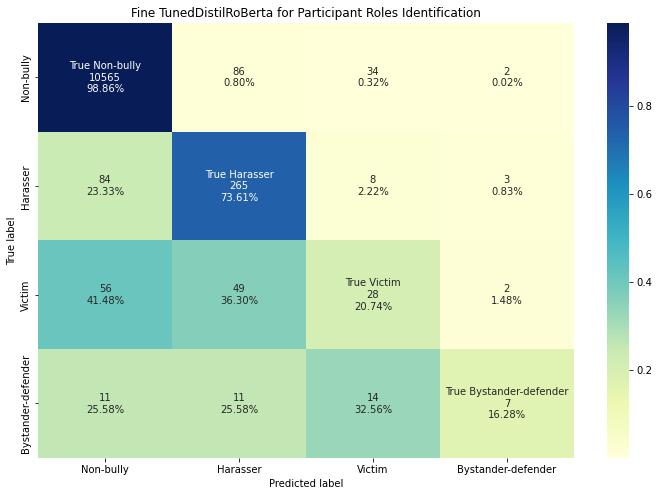

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-4775', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 2

loading configuration file content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-9550/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-9550",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "fl

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10687
           1       0.58      0.79      0.67       360
           2       0.24      0.32      0.27       135
           3       0.41      0.51      0.45        43

    accuracy                           0.96     11225
   macro avg       0.55      0.65      0.59     11225
weighted avg       0.97      0.96      0.96     11225


Macro Metrics:
Precision:  0.552808390072541
Recall:  0.6489266519120085
F-measure:  0.5935839660492138

Label 0: Non-bully
Precision:  0.9918048408614446
Recall:  0.9738935154861046
F-measure:  0.9827675747131863

Label 1: Harasser
Precision:  0.5757575757575758
Recall:  0.7916666666666666
F-measure:  0.6666666666666667

Label 2: Victim
Precision:  0.23626373626373626
Recall:  0.31851851851851853
F-measure:  0.2712933753943218

Label 3: Bystander-defender
Precision:  0.4074074074074074
Recall:  0.5116279069767442
F-measure:  0.4536082

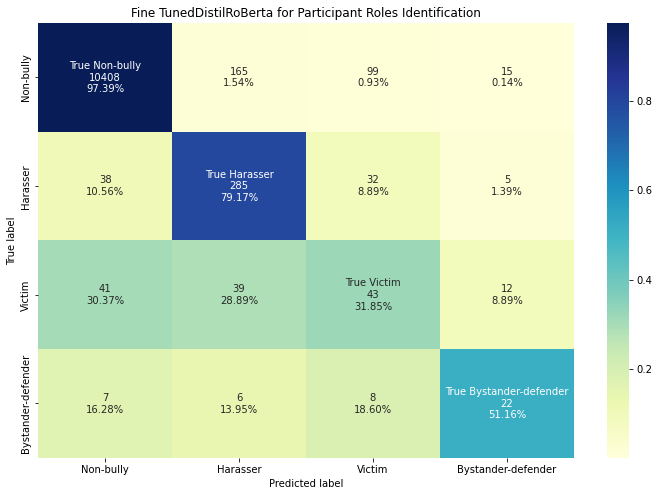

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-9550', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 3

loading configuration file content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-14325/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-14325",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.57      0.82      0.68       360
           2       0.28      0.22      0.25       135
           3       0.53      0.44      0.48        43

    accuracy                           0.96     11225
   macro avg       0.59      0.62      0.60     11225
weighted avg       0.97      0.96      0.96     11225


Macro Metrics:
Precision:  0.5927577347606877
Recall:  0.6163362161615854
F-measure:  0.5971588290164278

Label 0: Non-bully
Precision:  0.9903454803596782
Recall:  0.979039955085618
F-measure:  0.9846602672689628

Label 1: Harasser
Precision:  0.5725338491295938
Recall:  0.8222222222222222
F-measure:  0.6750285062713796

Label 2: Victim
Precision:  0.2803738317757009
Recall:  0.2222222222222222
F-measure:  0.24793388429752067

Label 3: Bystander-defender
Precision:  0.5277777777777778
Recall:  0.4418604651162791
F-measure:  0.48101265

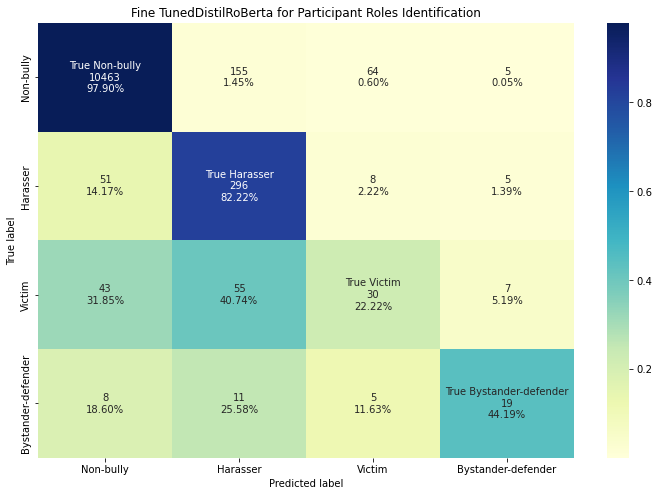

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-14325', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 4

loading configuration file content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-19100/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-19100",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10687
           1       0.64      0.83      0.72       360
           2       0.36      0.32      0.34       135
           3       0.51      0.51      0.51        43

    accuracy                           0.97     11225
   macro avg       0.63      0.66      0.64     11225
weighted avg       0.97      0.97      0.97     11225


Macro Metrics:
Precision:  0.6252421383913477
Recall:  0.6607308428813066
F-measure:  0.6396114430515109

Label 0: Non-bully
Precision:  0.990750353940538
Recall:  0.9822213904744082
F-measure:  0.9864674372709332

Label 1: Harasser
Precision:  0.6402569593147751
Recall:  0.8305555555555556
F-measure:  0.7230955259975815

Label 2: Victim
Precision:  0.35833333333333334
Recall:  0.31851851851851853
F-measure:  0.33725490196078434

Label 3: Bystander-defender
Precision:  0.5116279069767442
Recall:  0.5116279069767442
F-measure:  0.511627

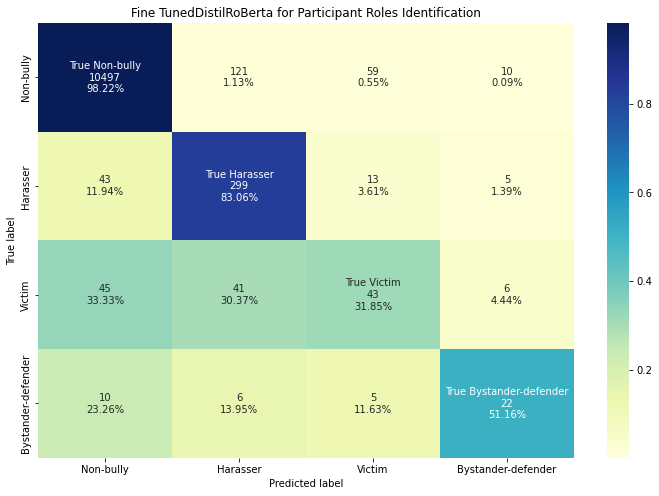

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-19100', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 5

loading configuration file content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-23875/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-23875",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.58      0.83      0.68       360
           2       0.41      0.30      0.34       135
           3       0.53      0.49      0.51        43

    accuracy                           0.96     11225
   macro avg       0.63      0.65      0.63     11225
weighted avg       0.97      0.96      0.97     11225


Macro Metrics:
Precision:  0.6257428974553172
Recall:  0.6487063324338045
F-measure:  0.6292417453095649

Label 0: Non-bully
Precision:  0.9903509601740611
Recall:  0.9796013848601104
F-measure:  0.984946843541255

Label 1: Harasser
Precision:  0.5794573643410853
Recall:  0.8305555555555556
F-measure:  0.682648401826484

Label 2: Victim
Precision:  0.40816326530612246
Recall:  0.2962962962962963
F-measure:  0.34334763948497854

Label 3: Bystander-defender
Precision:  0.525
Recall:  0.4883720930232558
F-measure:  0.5060240963855422



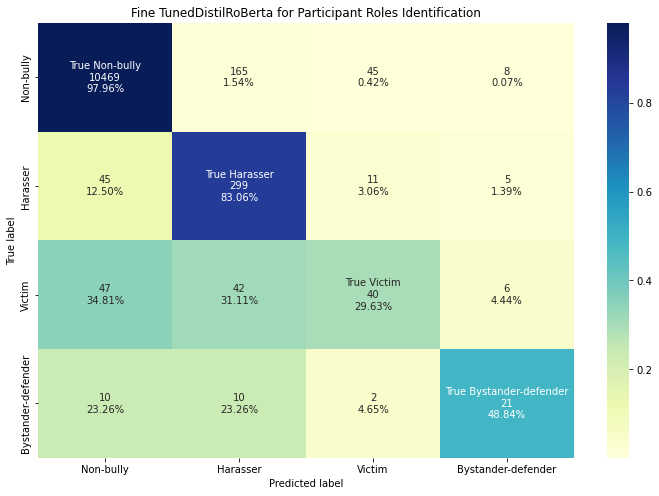

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-23875', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 6

loading configuration file content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-28650/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-28650",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10687
           1       0.58      0.81      0.68       360
           2       0.39      0.30      0.34       135
           3       0.57      0.47      0.51        43

    accuracy                           0.96     11225
   macro avg       0.63      0.64      0.63     11225
weighted avg       0.97      0.96      0.97     11225


Macro Metrics:
Precision:  0.6349255042104927
Recall:  0.6394226043144339
F-measure:  0.6298345769857504

Label 0: Non-bully
Precision:  0.9897053267850396
Recall:  0.9805371011509311
F-measure:  0.9850998824911869

Label 1: Harasser
Precision:  0.5843373493975904
Recall:  0.8083333333333333
F-measure:  0.6783216783216784

Label 2: Victim
Precision:  0.3942307692307692
Recall:  0.3037037037037037
F-measure:  0.3430962343096234

Label 3: Bystander-defender
Precision:  0.5714285714285714
Recall:  0.46511627906976744
F-measure:  0.5128205

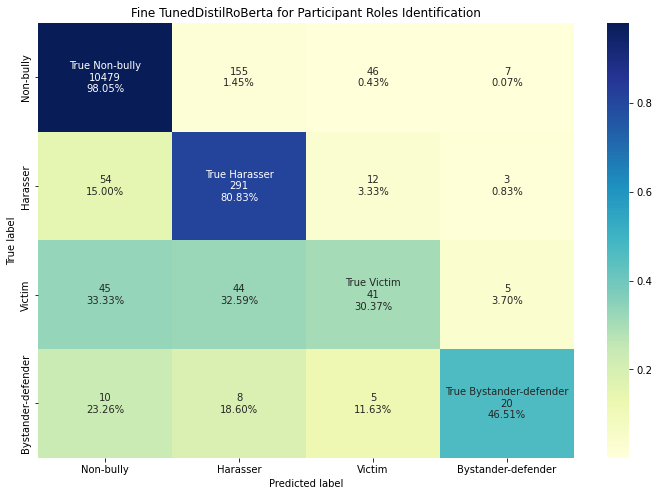

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-28650', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 7

loading configuration file content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-33425/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-33425",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.58      0.80      0.67       360
           2       0.39      0.33      0.36       135
           3       0.56      0.47      0.51        43

    accuracy                           0.96     11225
   macro avg       0.63      0.64      0.63     11225
weighted avg       0.97      0.96      0.97     11225


Macro Metrics:
Precision:  0.6297253948178436
Recall:  0.6439118765004405
F-measure:  0.6308220377670735

Label 0: Non-bully
Precision:  0.9899801493524908
Recall:  0.9799756713764387
F-measure:  0.9849525063481614

Label 1: Harasser
Precision:  0.5786290322580645
Recall:  0.7972222222222223
F-measure:  0.6705607476635514

Label 2: Victim
Precision:  0.39473684210526316
Recall:  0.3333333333333333
F-measure:  0.36144578313253006

Label 3: Bystander-defender
Precision:  0.5555555555555556
Recall:  0.46511627906976744
F-measure:  0.50632

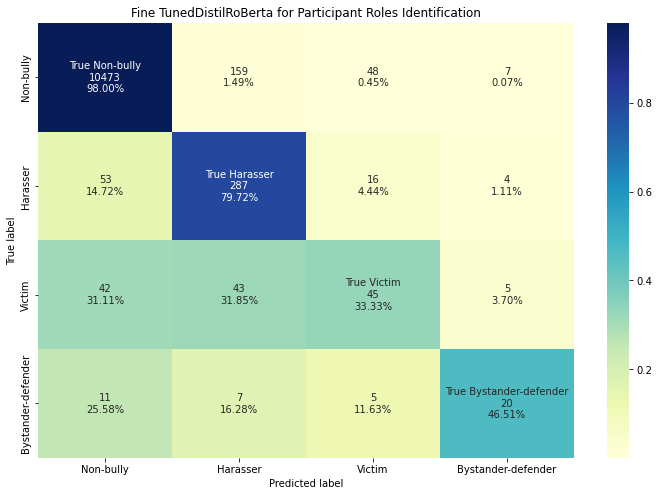

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-33425', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 8

loading configuration file content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-38200/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-38200",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.57      0.81      0.67       360
           2       0.37      0.35      0.36       135
           3       0.50      0.51      0.51        43

    accuracy                           0.96     11225
   macro avg       0.61      0.66      0.63     11225
weighted avg       0.97      0.96      0.96     11225


Macro Metrics:
Precision:  0.6074517174257814
Recall:  0.662684973722169
F-measure:  0.6295319307549982

Label 0: Non-bully
Precision:  0.9907960907106936
Recall:  0.9770749508748947
F-measure:  0.9838876849147271

Label 1: Harasser
Precision:  0.5689320388349515
Recall:  0.8138888888888889
F-measure:  0.6697142857142857

Label 2: Victim
Precision:  0.3700787401574803
Recall:  0.34814814814814815
F-measure:  0.3587786259541985

Label 3: Bystander-defender
Precision:  0.5
Recall:  0.5116279069767442
F-measure:  0.5057471264367817



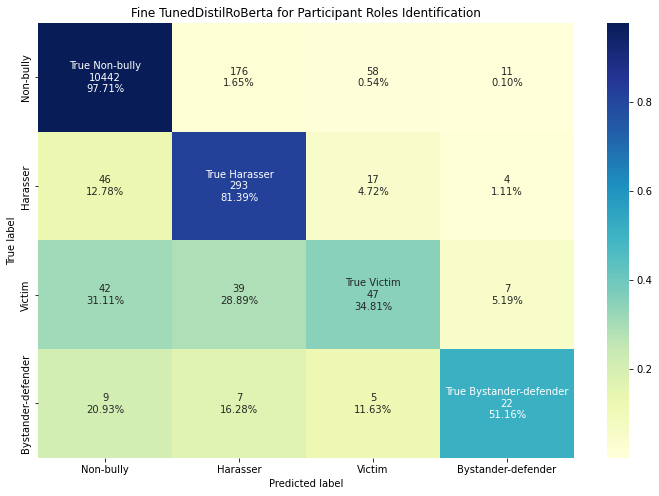

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-38200', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 9

loading configuration file content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-42975/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-42975",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.59      0.82      0.69       360
           2       0.35      0.33      0.34       135
           3       0.55      0.51      0.53        43

    accuracy                           0.96     11225
   macro avg       0.62      0.66      0.64     11225
weighted avg       0.97      0.96      0.97     11225


Macro Metrics:
Precision:  0.6196174018063925
Recall:  0.6607444454236825
F-measure:  0.6352330820823279

Label 0: Non-bully
Precision:  0.9908100426338229
Recall:  0.9785720969402077
F-measure:  0.9846530458525563

Label 1: Harasser
Precision:  0.5888223552894212
Recall:  0.8194444444444444
F-measure:  0.6852497096399536

Label 2: Victim
Precision:  0.3488372093023256
Recall:  0.3333333333333333
F-measure:  0.3409090909090909

Label 3: Bystander-defender
Precision:  0.55
Recall:  0.5116279069767442
F-measure:  0.5301204819277109



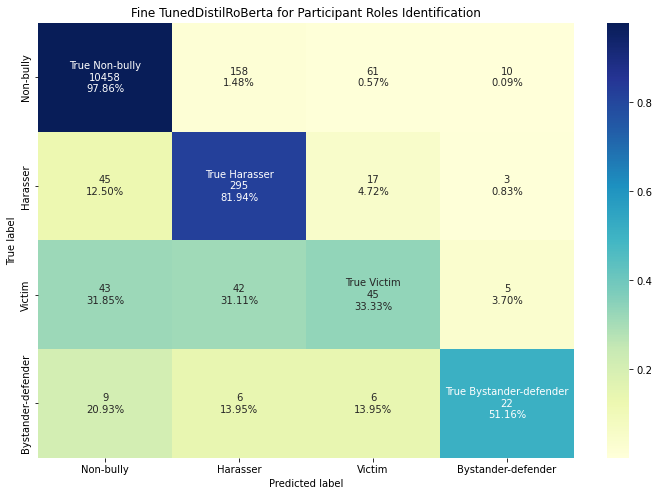

In [11]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-42975', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 10

loading configuration file content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-47750/config.json
Model config RobertaConfig {
  "_name_or_path": "content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-47750",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10687
           1       0.58      0.81      0.68       360
           2       0.35      0.36      0.35       135
           3       0.51      0.56      0.53        43

    accuracy                           0.96     11225
   macro avg       0.61      0.68      0.64     11225
weighted avg       0.97      0.96      0.96     11225


Macro Metrics:
Precision:  0.6079883765236089
Recall:  0.676164732550765
F-measure:  0.6369971839365132

Label 0: Non-bully
Precision:  0.9909841510866471
Recall:  0.9770749508748947
F-measure:  0.9839803995476819

Label 1: Harasser
Precision:  0.5825049701789264
Recall:  0.8138888888888889
F-measure:  0.679026651216686

Label 2: Victim
Precision:  0.34782608695652173
Recall:  0.35555555555555557
F-measure:  0.3516483516483516

Label 3: Bystander-defender
Precision:  0.5106382978723404
Recall:  0.5581395348837209
F-measure:  0.53333333

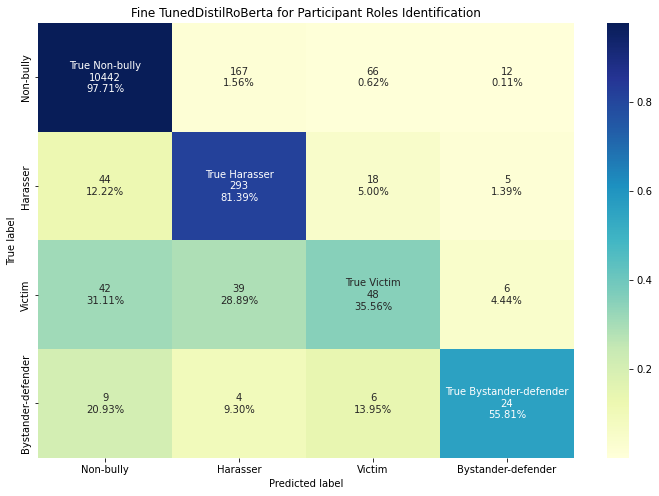

In [12]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-47750', 
                        average_method='macro',
                        X_test=X_test)

#### Epoch 1

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_val)

#### Epoch 2

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_val)

#### Epoch 3

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_val)

#### Epoch 4

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_val)

#### Epoch 5

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_val)

#### Epoch 6

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_val)

#### Epoch 7

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_val)

#### Epoch 8

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_val)

#### Epoch 9

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_val)

#### Epoch 10

In [ ]:
compute_metrics_holdout(model_name='DistilRoBerta',
                        model_path='content/drive/MyDrive/output_DistilRoBerta/holdout/checkpoint-3820', 
                        average_method='macro',
                        X_test=X_val)